# Crypto Pumps

This example demonstrates the flexibility of Fintuna. We want to predict short-term crypto pumps. In other words, we want to predict wich crypto asset are most likely to yield abnormally high returns within the next 24 hours. The assumption is that moderate price changes are random and hard to predict, but abnormal returns have patterns that can be captured. But we don't know exactly how extreme these returns must be. Should we try to predict the top 2% or the top 20% of returns? 

We use Fintuna to select the optimal value automatiaclly and further explore how profitable such a strategy would be. 

In [1]:
import optuna
from matplotlib import pyplot as plt
import shap
import fintuna as ft

Crypto assets are highly correlated. Therfore, if one asset is increasing in value, it's hard to say whether something happened to that particular asset or wether the overall market increased. Therefore, we are going to predict an asset's change in comparision to Bitcoin, which we use as a proxy of the crypto market. In other words, we are going to predict BTC-pairs and not USDT-pairs. As features we will returns, trading volume and sentiment provided by [cortecs.ai](https://cortecs.ai). We assume that social sentiment is highly connected with those crypto pumps. We ran some preprocessing steps (such as feature lagging) and packaged the data to be ready-to-use. 

In [2]:
data, data_specs = ft.data.get_btcpairs_with_social_sentiment()
print(f'Supported assets: {list(data.fin.asset_names)}')

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Supported assets: ['ETHBTC', 'LTCBTC', 'XRPBTC', 'LINKBTC', 'BNBBTC', 'TRXBTC', 'XLMBTC', 'XTZBTC', 'ADABTC', 'EOSBTC', 'BCHBTC', 'XMRBTC', 'DASHBTC', 'NEOBTC', 'ATOMBTC', 'ZECBTC', 'BATBTC', 'VETBTC', 'SUSHIBTC', 'UNIBTC', 'AAVEBTC', 'ALGOBTC', 'DOTBTC', 'ETCBTC', 'SOLBTC', 'DOGEBTC', 'MATICBTC', 'HNTBTC', 'YFIBTC', 'ZILBTC']


The data has a sampling frequency of 3 hours (see `data_specs`) and ranges from 2020-01-02 to 2022-09-08.
The data contains 30 assets each having 107 features. 

The `Pumps` strategy is ready-to-use and we don't have to implement it ourselves. So, let's create a finstudy and `explore` how it performs. We use 100 tuning iterations and an ensemble size of 4 (this will take a while).

In [3]:
crypto_pumps_study = ft.FinStudy(ft.model.Pumps, data, data_specs=data_specs)
results = crypto_pumps_study.explore(n_trials=100, ensemble_size=4)

[I 2022-10-04 19:42:32,153] A new study created in memory with name: finstudy


INFO:train:start tuning


INFO:train:iteration 1/100


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] lambda_l1 is set=0.20547625125911342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20547625125911342
[LightGBM] [Warning] lambda_l2 is set=4.734989304499476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.734989304499476
[LightGBM] [Warning] feature_fraction is set=0.6917207594128889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6917207594128889


INFO:train:iteration 2/100


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] lambda_l1 is set=0.011498870747119453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011498870747119453
[LightGBM] [Warning] lambda_l2 is set=3.146730406166005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.146730406166005
[LightGBM] [Warning] feature_fraction is set=0.9350060741234096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9350060741234096


KeyboardInterrupt: 

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


-1.9028148836798153

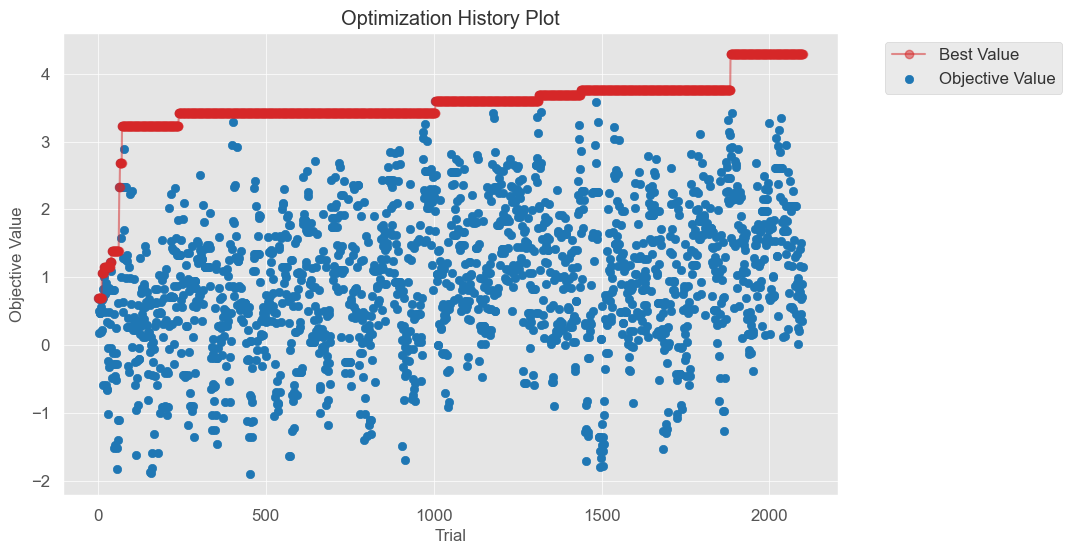

In [14]:
optuna.visualization.matplotlib.plot_optimization_history(crypto_pumps_study.study)
crypto_pumps_study.study.trials_dataframe()['value'].min()
# plt.tight_layout()

We see the outputs of all trials (`n_trials x conf_thrshold_trials`). We inspect that outputs tend to provide positive results with an average of 95% cumulative returns (0.95 on the y-axis). But the variance is high ranging from gains of 428% to losses of 190%. With `ensemble_size` set to 4, we will use the best 4 models to compute an out-of-sample backtest.

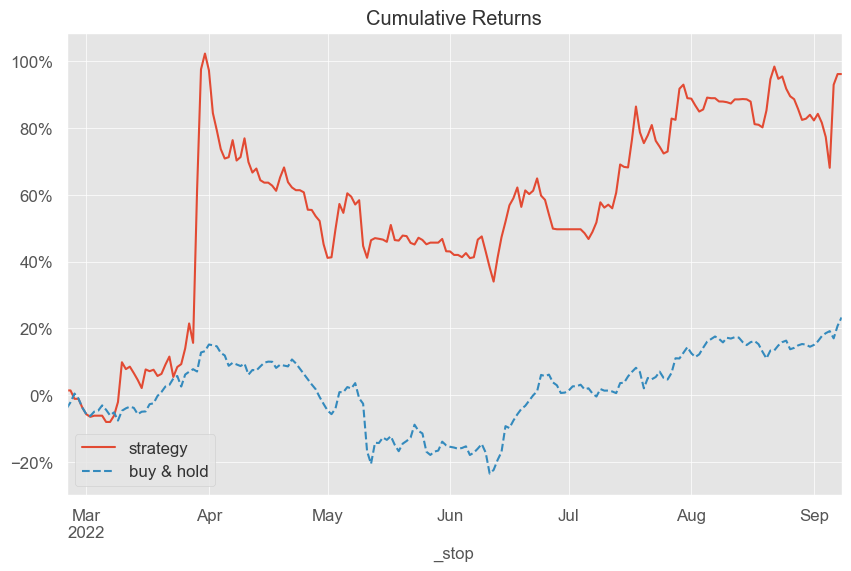

In [5]:
ft.utils.plot_backtest(results['performance'], results['benchmark'])
## to retrieve a detailed html-trading report
# ft.utils.create_tearsheet(results['performance'], results['benchmark'], 'crypto_pumps_tearsheet.html')

The backtest yields 96% cumulative returns. It seems to have detected pumps at the end of March and at the beginning of September. Keep in mind that we are predicting BTC-pairs. So those returns are in BTC. If we would have used our strategy we would have ended up with +96% of BTC while buy-and-hold would have returned +23%.

In [6]:
metrics = ft.utils.get_performance_metrics(results['performance'], results['benchmark'])
metrics.loc[['Time in Market ', 'Total Return ', 'Sortino', 'Max Drawdown '], :]

,Strategy,Benchmark
Time in Market,0.92,1.0
Total Return,0.96,0.23
Sortino,3.54,1.38
Max Drawdown,-0.52,-0.34


By default Fintuna selects a confidence threshold when to enter a position. If this threshold is not reached, nothing is allocated which explains the `Time in Market` of 92%. A `Sortino` of 3.54 is pretty confincing. But the `Max Drawdown` of -52% indicates that further risk management is necessary.

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.


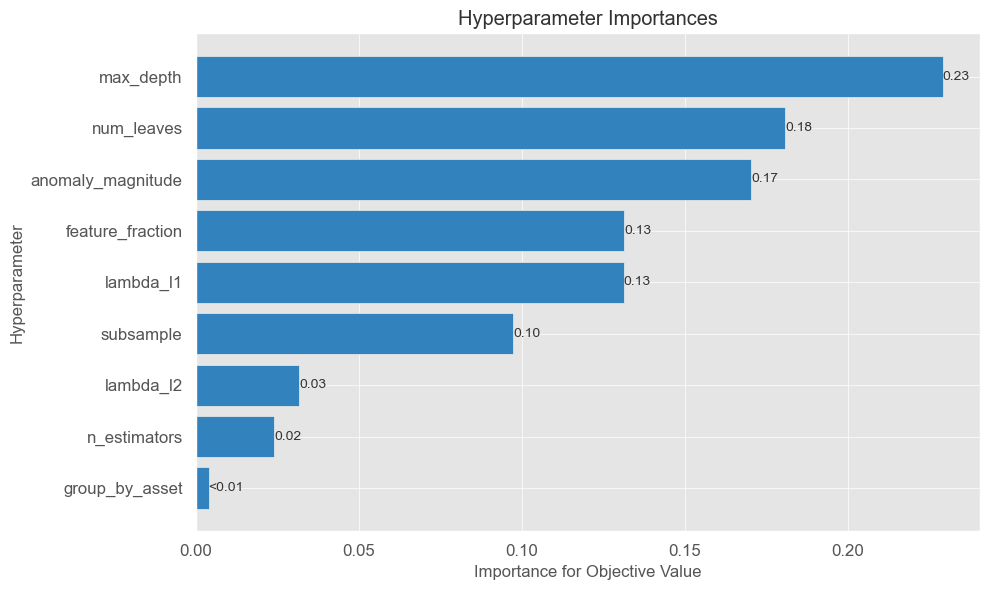

In [7]:
optuna.visualization.matplotlib.plot_param_importances(crypto_pumps_study.study)
plt.tight_layout()

By looking at the hyper-parameter importance, we see that the tree-depth, the number of leaves and the threshold to label sometings as "pump" (= `anomaly_magnitude`) are essential .    

<AxesSubplot:xlabel='params_anomaly_magnitude', ylabel='value'>

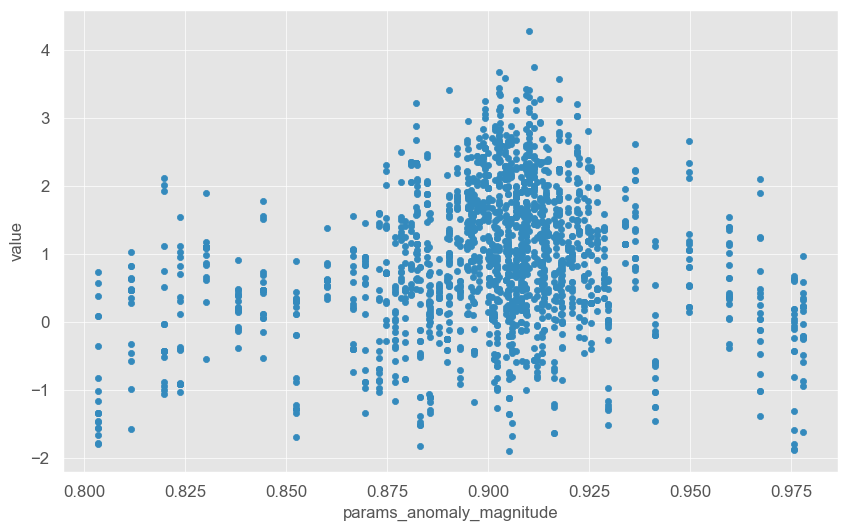

In [8]:
crypto_pumps_study.study.trials_dataframe().plot.scatter(x='params_anomaly_magnitude', y='value')

Looking closer, we see that the best performance is achieved by predicting the top 8-10% (0.9-0.92 on the x-axis) returns. 

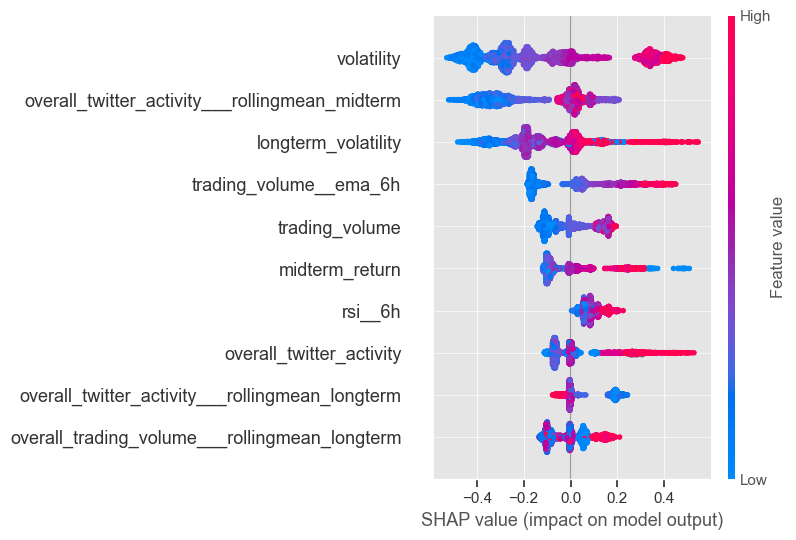

In [9]:
shap.summary_plot(results['shap'][0].values, results['shap'][2], max_display=10, show=False)
plt.tight_layout()

The most important features for detecting pumps are volatility-based. Of course the probability of an asset to yield abnormally high returns is dependend on it's volatility (the probability to yield abnormally low returns as well). I assume that top-level splits are based on past volatility while deeper splits take more subtle features such as *twitter activity* and *sentiment* into account. 